In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
# Consider aesthetics
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['axes.axisbelow'] = True
plt.rcParams.update({'font.size': 13})

# **Problem 1: RNA folding**
Find all optimal secondary structures of the RNA sequence $AAUACUCCGUUGCAGCAU$ with the following
crude energy minimization algorithm. Starting from the slides’ algorithm, use the following initialisation:
$j + 5 > i \Rightarrow E(i, j) = 100, i > j$
and bond energy $b(i, j) = −4, 0, 4$ for Watson-Crick bonds, GU, and all other possible pairs respectively.
Implement your algorithm in Matlab, R, Python or other convenient system; submit your code. Print the
filled-in table $E$. Draw (by hand) an optimal fold, show its bonds, and the corresponding backtrack path.

## *Solution*
To implement all that into code:
1. we first define `bond_energy` which returns one of the appropriate bond scores mentioned before based on the bases of the bond:
- Watson-Crick bonds have energy $= -4$ 
- Unfavorable bonds have energy $= 4$
- GU bonds have energy $= 0$


2. We create the `crude_energy_minimization` function, it takes as input an RNA sequence and outputs the crude energy minimization table E, along with the backtrack matrix. 
   1. First, beginning from the last row and the first column of the matrix, it places $100$ following the rule j+5 > i $\Rightarrow$  E(i,j) = $100$ 
   2. Then for each remaining position it fills it with the minimum value of: $$E(i,j) = min\begin{cases}E(i-1m,j),\\ 
                                                   E(i,j+1),\\
                                                   E(i-1,j+1) + bond energy(r_i,r_j), \\
                                                   min_k\{E(i,k) + E(k-1,j) : j+1 < k < 1\}\end{cases}$$
   3. The back-track matrix is filled based on the index of the minimum value in the cases above

In [2]:
# Create a function to return the corresponding bond energy
def bond_energy(row, col, sequence):
    if (sequence[col] == "A" and sequence[row] == "U") or \
            (sequence[col] == "U" and sequence[row] == "A"):
        return -4
    elif (sequence[col] == "C" and sequence[row] == "G") or \
            (sequence[col] == "G" and sequence[row] == "C"):
        return -4
    elif (sequence[col] == "G" and sequence[row] == "U") or \
            (sequence[col] == "U" and sequence[row] == "G"):
        return 0
    else:
        return 4


def crude_energy_minimization(sequence):
    size = len(sequence)
    matrix = np.zeros((size, size))
    matrix_bt = np.zeros((size, size))

    # First of all we initialize the matrix
    for row in range(size-1, -1, -1):
        for col in range(size):
            # When the bases are too close, insert a very high energy cost
            if col - 5 < row:
                matrix[row, col] = 100
                # Also fill the backtrack matrix
                matrix_bt[row, col] = np.inf
            else:
                # Once the high energy close base cases have been investigated
                # move to the rest of the sequences assigning energy based on the
                # cases displayed above
                value = [
                    matrix[row, col-1],
                    matrix[row+1, col],
                    matrix[row+1, col-1] + bond_energy(row, col, sequence),
                    min(matrix[row, k-1] + matrix[k, col]
                        for k in range(row+2, col))
                ]
                min_value = np.min(value)
                matrix[row, col] = min_value
                # Check how many times the min value appears in the list
                min_indexes = [str(i+1) for i in range(
                    len(value)) if value[i] == min_value]
                # concatinate the result to contain all possibilites
                result_float = float("".join(min_indexes))
                matrix_bt[row, col] = result_float
    return matrix, matrix_bt

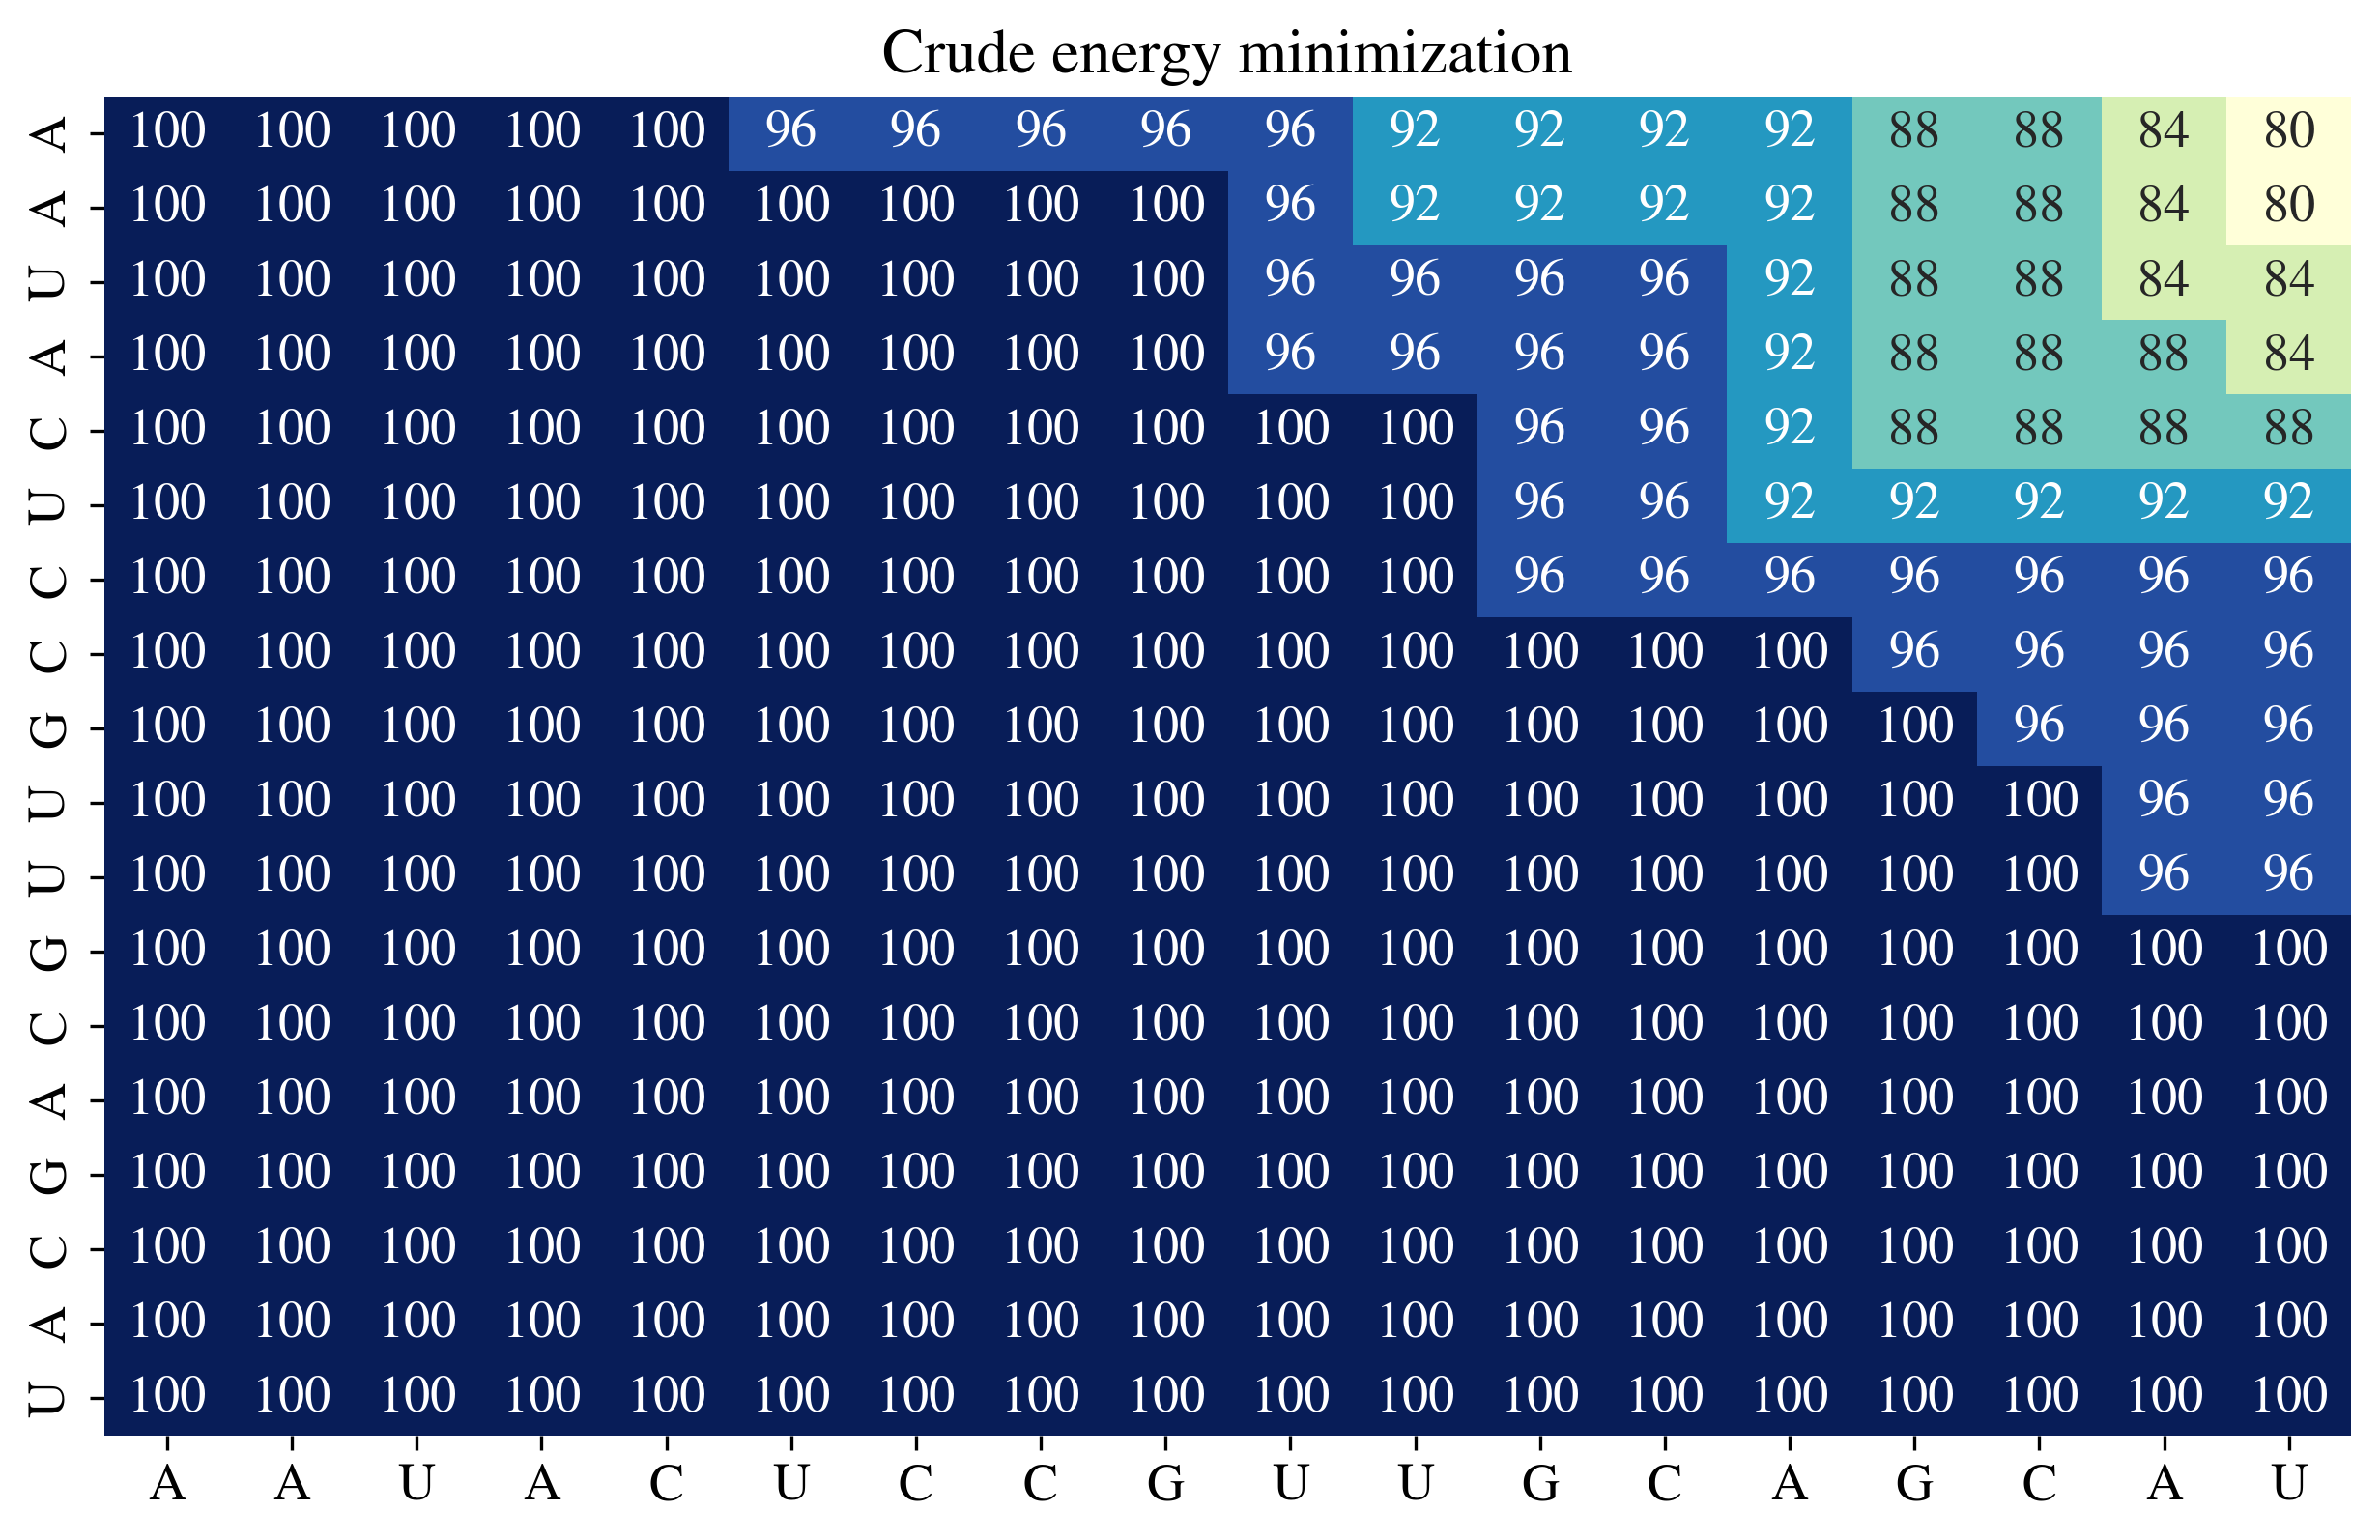

c:\Users\cinna\anaconda3\lib\site-packages\matplotlib\colors.py:1354: RuntimeWarning: invalid value encountered in true_divide
  resdat /= (vmax - vmin)


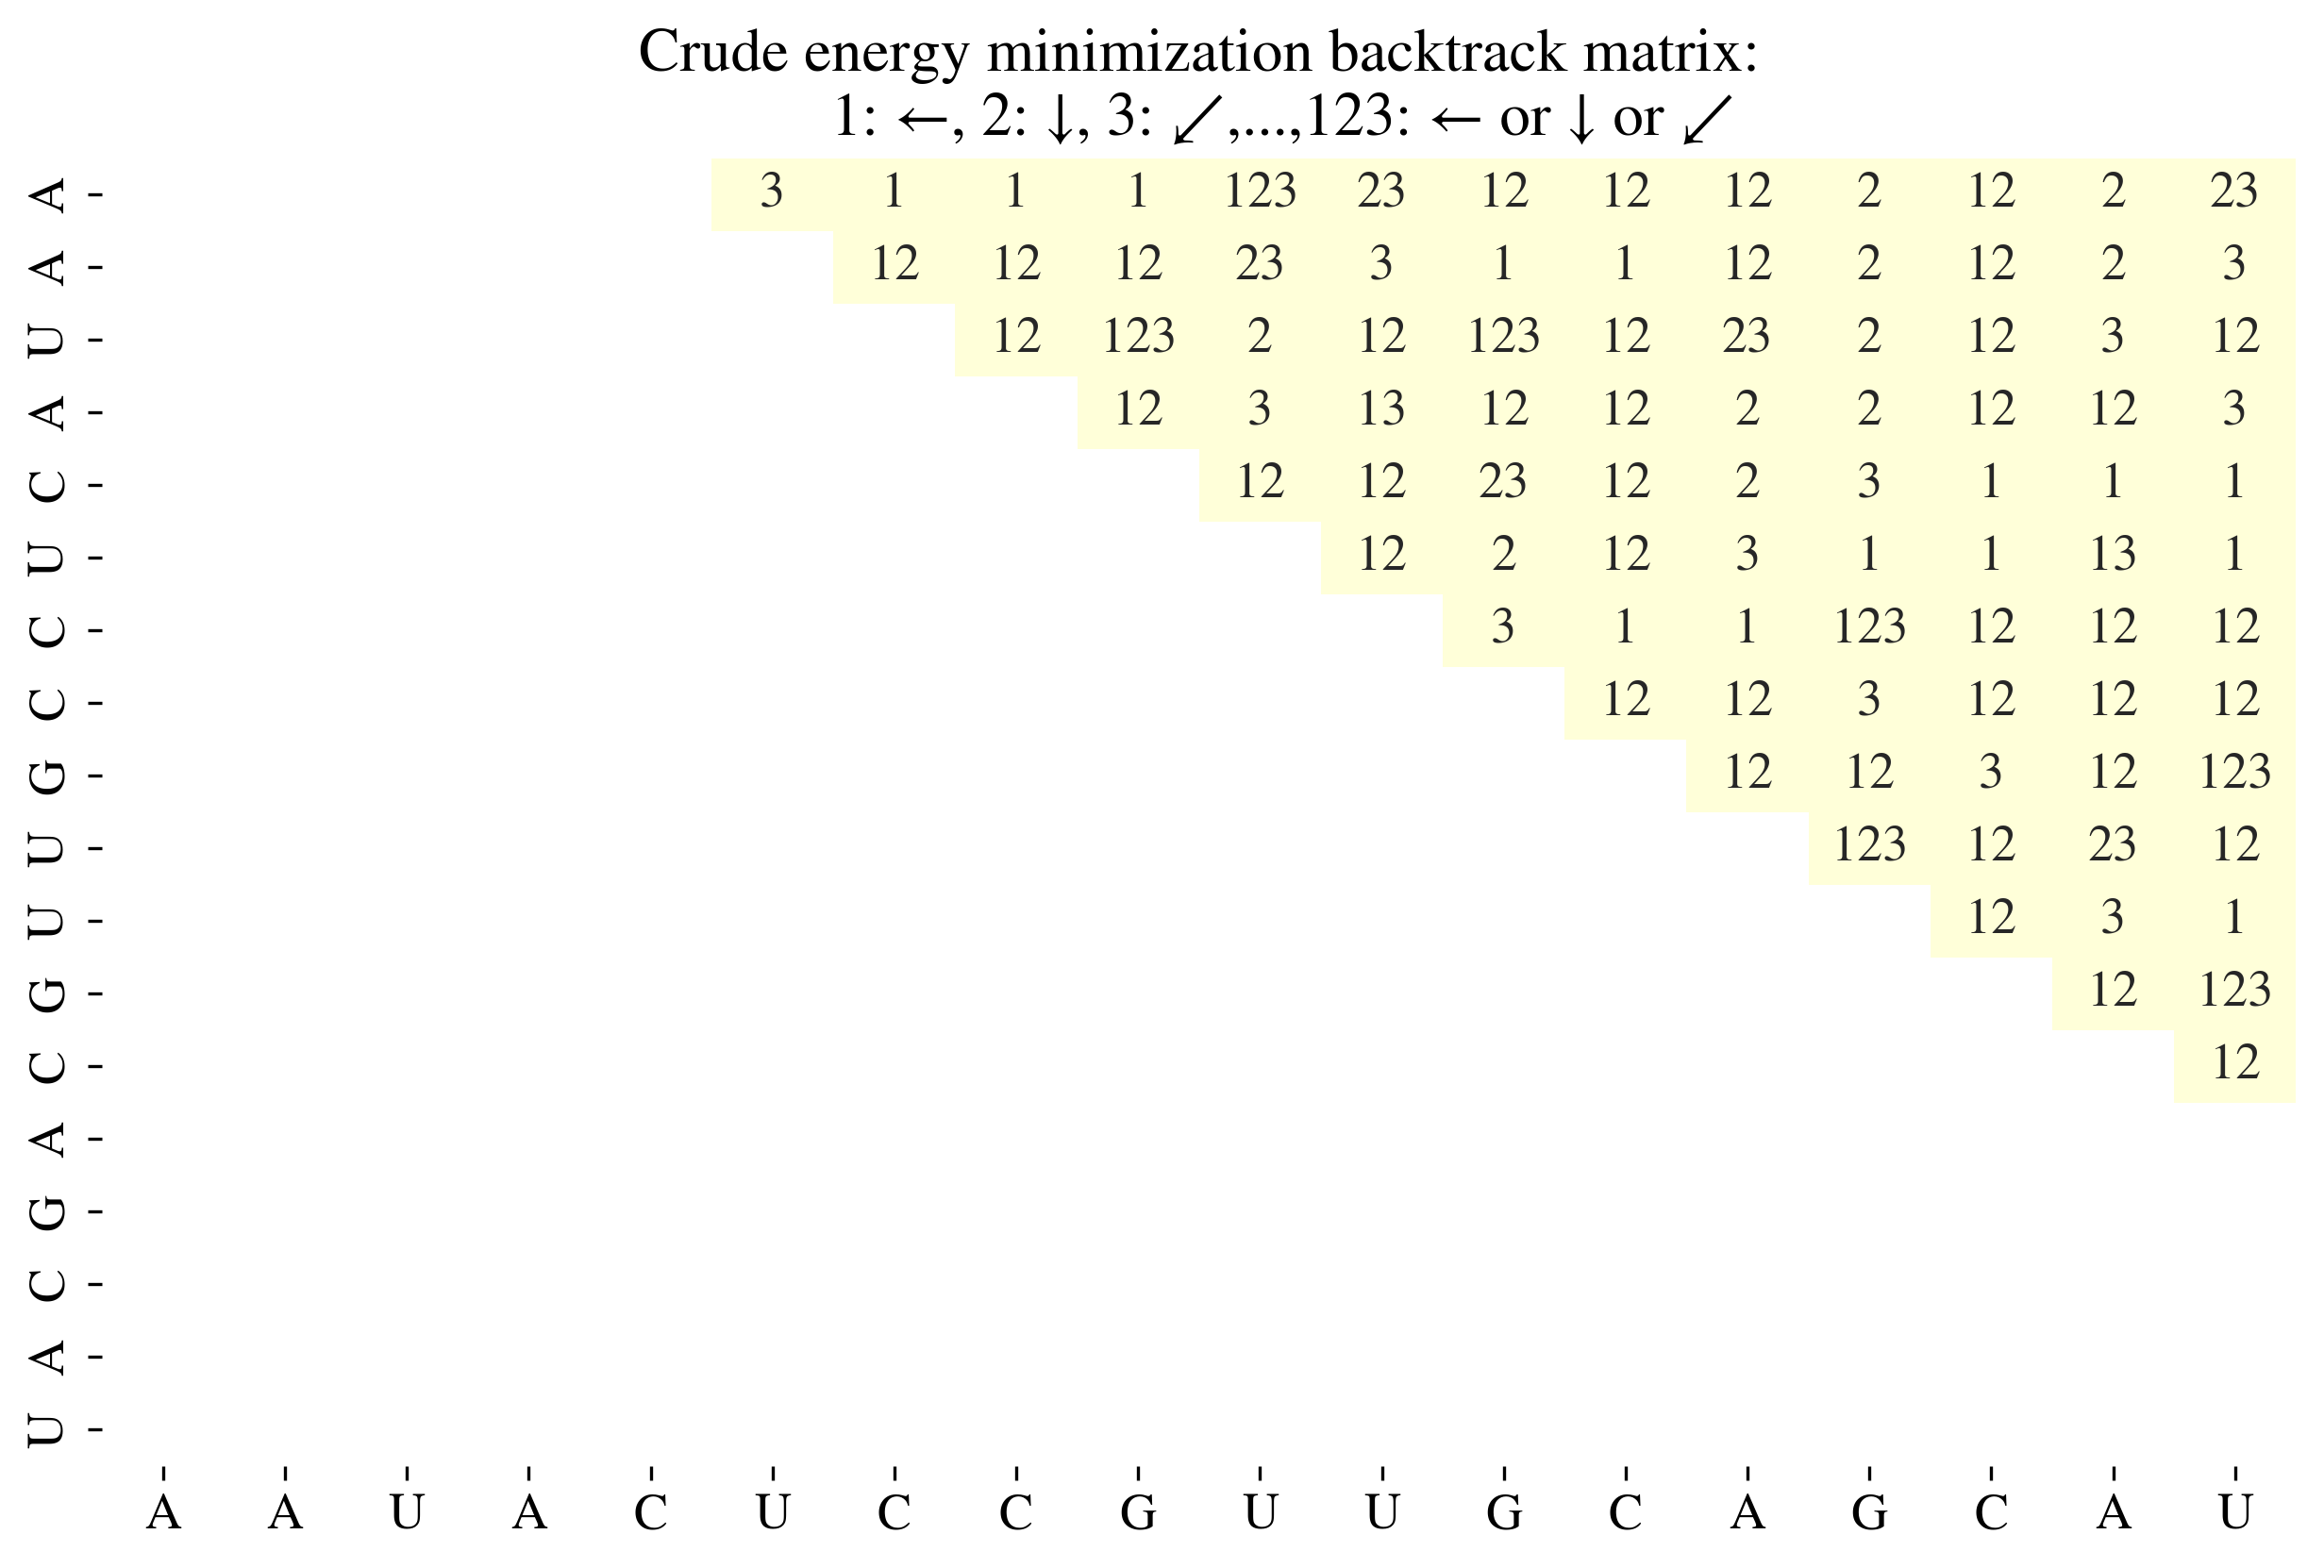

In [3]:
seq = "AAUACUCCGUUGCAGCAU"
matrix, matrix_bt = crude_energy_minimization(seq)
plt.figure(figsize=(10, 6), dpi=300)
plt.title("Crude energy minimization")
sns.heatmap(matrix, cmap="YlGnBu", annot=True, cbar=False,
            xticklabels=seq, yticklabels=seq, fmt=".0f")
plt.show()
plt.figure(figsize=(10, 6), dpi=300)
plt.title("Crude energy minimization backtrack matrix:\n \
          1: \u2190, 2: \u2193, 3: \u2199,...,123: \u2190 or \u2193 or \u2199")
sns.heatmap(matrix_bt, cmap="YlGnBu", annot=True, cbar=False,
            xticklabels=seq, yticklabels=seq, fmt=".0f")
plt.show()


---

# **Problem 2: c-RMSD and d-RMSD**
Given are 10 conformations of a specific molecule in file "10_conformations.txt"
with $n = 369$ atoms on the backbone (hence in correspondence). The table starts with 2 lines containing $10$ and
$n = 369$. The rest of the tale uses tabs to deine $3$ columns containnig n triplets $x \ y\ z$ of each conformation
hence $2 + 10n =3692$ rows.

Implement c-RMSD and d-RMSD in Matlab, Mathematica, Maple or other system offering linear algebra
(SVD); submit your code. If your system provides either of these functions, it is OK to just use it.

1. Compute the c-RMSD distances between all ${10 \choose 2}$ pairs of conformations. Compute the pairs of conformations. Compute the mean and median c-RMSD distance and draw a histogram of all distances in 10 classes.
1. Repeat (1) for d-RMSD using all $k = {n \choose 2}$ distances within each conformation, or a random subset of $k = 3n$ distances.

## *Solution*
First of all we load the  x, y, z coordinates from the file and store them in a data-frame:

In [4]:
df = pd.read_csv("10_conformations.txt", header=None, sep="\t", skiprows=2)
df.columns = ["X", "Y", "Z"]
df.shape

(3690, 3)

Since this dataframe contains 10 conformations of the molecule we reshape it into a an array of 10 conformations with 369 atoms each and their respective x, y, z coordinates:

In [5]:
conformation_cords = df.values
conformation_cords = conformation_cords.reshape(10, 369, 3)
conformation_cords.shape

(10, 369, 3)

### **Task 1: Compute the c-RMSD distances between all ${10 \choose 2}$ pairs of conformation, find the L1 centroid. Plot the histograms of the 10 conformations**

pairs of conformations. Use them to find the L1-centroid
conformation i.e. the one that minimizes the sum of distances to the other 9 conformations**

c-RMSD is given by the following formula:
$$c-RMSD = \sqrt{\frac{1}{n} \sum_{i=1}^n||x_{i} - y_{i}||^2}$$
where $x_{i}$ and $y_{i}$ are the $i$-th carbon atom coordinates for the two conformations we are comparing.

In order to be able to compare the conformations based on point distance in the 3D space of the carbona atoms we need to superimpose them. This requires that we translate and rotate the conformations so that they are as similar as possible, thus having the lowest possible c-RMSD. Optimal translation can be decoupled from rotation optimization, so we will first find the optimal translation and then the optimal rotation.

**Optimal Translation:**
First of all we need to translate the coordinates of all the conformations to the origin. This can be done by subtracting the mean of the coordinates from each coordinate. To achieve this we define the `optimal_translation` function which takes as input the coordinates of the conformations and returns the coordinates of the conformations translated to the origin.

In [6]:
def optimal_translation(X, Y):
    X = X - X.mean(axis=0)
    Y = Y - Y.mean(axis=0)
    return X, Y

**Optimal Rotation:** 
To find the optimal rotation matrix we first find the covariance matrix $\Sigma$ of the two conformations. Since both conformations have a mean of $[0,0,0]$ This is done by multiplying the transpose of the first conformation matrix $X^T$ with the second conformation $Y$ and dividing with the number of atoms. Since we have three dimensions we get a $3x3$ covariance matrix $\Sigma$:

$$\Sigma = \frac{1}{n} X^{T}Y$$ 

Using Singular Value Decomposition (SVD) we can decompose the covariance matrix into: $$\Sigma = U S V^{T}$$
- where $U$ and $V$ are orthogonal matrices containing the left and right singular vectors of $\Sigma$ respectively
- $S$ is a diagonal matrix containing the singular values of $\Sigma$ on the diagonal in descending order

An optimal rotation matrix $Q$ should satisfy:
$$V^TQ^TU = I$$ 
Thus $Q = V U^T$ is the optimal rotation matrix.

In case $det(Q) = -1$, that means that the rotation matrix is a reflection, we need to correct this by multiplying the last column of $U$ with -1 to get the optimal rotation matrix $Q$.


In [7]:
def optimal_rotation(X, Y):
    # number of atoms
    N = X.shape[0]
    # compute the covariance matrix
    cov = np.dot(X.T, Y)/N
    # SVD of the covariance matrix
    U, S, V = np.linalg.svd(cov)
    # compute the optimal rotation matrix
    Q = U @ V
    # check if the determinant is positive
    if np.linalg.det(Q) < 0:
        U[:, -1] = -U[:, -1]
        Q = U @ V
    return X @ Q

Now that we have coded `optimal_rotation` and `optimal_translation` we can use them to compute the c-RMSD distances using the equation for c-RMSD presented above and coded in `calculate_RMSD` as shown below.

In [8]:
def calculate_RMSD(X, Y):
    # number of atoms
    N = X.shape[0]
    # calculate the RMSD
    RMSD = (np.sum((X-Y)**2)/N)**(1/2)
    return RMSD

We utilize these three functions in a nested for loop to calculate the c-RMSD distances between all ${10 \choose 2}$ pairs of conformations and store them in a matrix, which we then pass in a dataframe and visualize them in a heatmap. Of course we dont compute the c-RMSD distance between a conformation and itself, as well as repeating pairs of conformations. Thus we get an upper triangular matrix with the c-RMSD distances between all  between all ${10 \choose 2}$ pairs.

In [9]:
# initialize the matrix
conformation_rmsd = np.zeros((10, 10))
# timer start
start_time = time.time()
for i in range(10):
    for j in range(i+1, 10):
        # Use the optimal translation and rotation functions and calculate the RMSD
        X, Y = optimal_translation(
            conformation_cords[i], conformation_cords[j])
        X = optimal_rotation(conformation_cords[i], conformation_cords[j])
        RMSD = calculate_RMSD(conformation_cords[i], conformation_cords[j])
        # populate the matrix
        conformation_rmsd[i, j] = RMSD
# timer end
end_time = time.time()
cRMSD_elapsed_time = end_time - start_time
# pass the matrix to a pandas dataframe
RMSD_df = pd.DataFrame(conformation_rmsd, columns=[
                       f"Conf {i+1}" for i in range(10)], index=[f"Conf {i+1}" for i in range(10)])
print(f"{np.count_nonzero(conformation_rmsd)} c-RMSD distances were calculated")
RMSD_df

45 c-RMSD distances were calculated


,Conf 1,Conf 2,Conf 3,Conf 4,Conf 5,Conf 6,Conf 7,Conf 8,Conf 9,Conf 10
Conf 1,0.0,0.631258,12.066002,11.985592,13.103253,13.033557,12.167073,12.166149,12.018696,11.453182
Conf 2,0.0,0.000000,12.024497,11.943902,13.053759,12.984079,12.139809,12.137896,11.983152,11.410660
Conf 3,0.0,0.000000,0.000000,0.758024,10.601870,10.605945,9.985104,10.023013,8.313910,8.353650
Conf 4,0.0,0.000000,0.000000,0.000000,10.582315,10.576534,9.977443,10.015295,8.329896,8.368920
Conf 5,0.0,0.000000,0.000000,0.000000,0.000000,1.188770,11.651580,11.737153,10.228171,11.317596
Conf 6,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,11.511691,11.580832,10.136712,11.246858
Conf 7,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.679389,10.411648,10.527550
Conf 8,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.422573,10.541474
Conf 9,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.131927
Conf 10,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


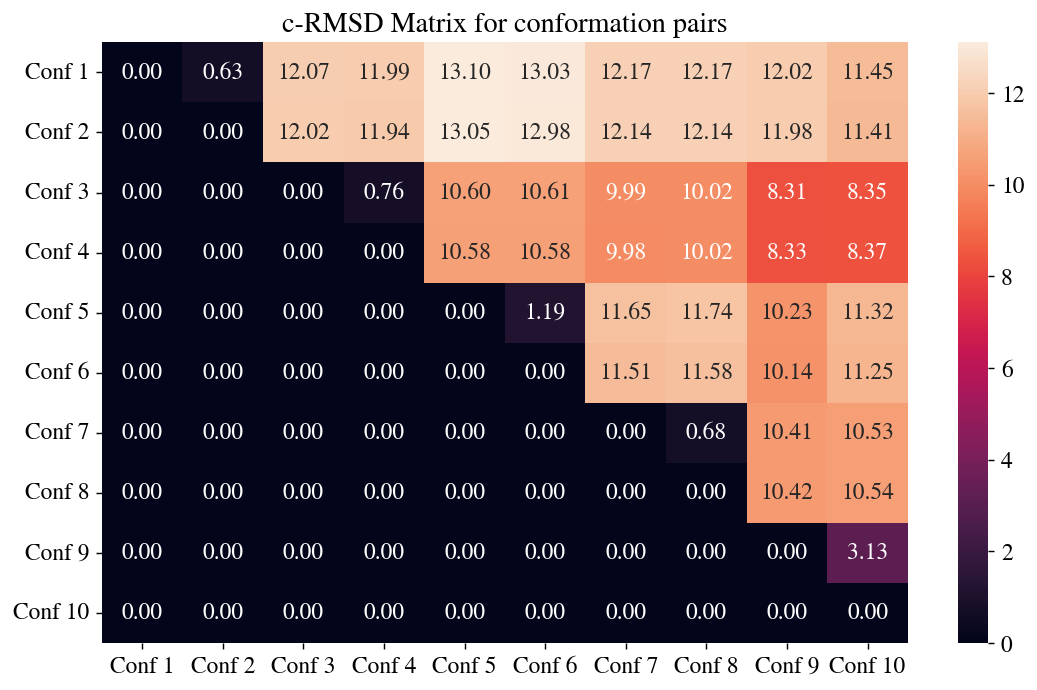

In [103]:
plt.figure(figsize=(10, 6), dpi=130)
sns.heatmap(RMSD_df, annot=True, cmap="rocket", fmt=".2f")
plt.title("c-RMSD Matrix for conformation pairs")
plt.show()


We now pass the c-RMSD distance of each conformation with the others in their respective columns to be able to calculate the mean and median c-RMSD distance. This will allow us to find the L1-centroid

In [11]:
cRMSD_dict = {}
for i in range(10):
    cRMSD_dict[f"Conformation {i + 1}"] = (np.concatenate(
        (conformation_rmsd[i, :], conformation_rmsd[:, i]), axis=0))
    cRMSD_dict[f"Conformation {i + 1}"] = cRMSD_dict[f"Conformation {i + 1}"][cRMSD_dict[f"Conformation {i + 1}"] != 0]
cRMSD_dict_df = pd.DataFrame(cRMSD_dict)

The mean and median c-RMSD distance for each conformation with respect to the other conformations are:

In [12]:
mean_cRMSD = cRMSD_dict_df.mean(axis=0).to_frame(name="Mean c-RMSD").T
mean_cRMSD

,Conformation 1,Conformation 2,Conformation 3,Conformation 4,Conformation 5,Conformation 6,Conformation 7,Conformation 8,Conformation 9,Conformation 10
Mean c-RMSD,10.958307,10.923224,9.192446,9.17088,10.384941,10.318331,9.894587,9.922642,9.441854,9.594646


In [13]:
median_cRMSD = cRMSD_dict_df.median(axis=0).to_frame(name="Median c-RMSD").T
median_cRMSD

,Conformation 1,Conformation 2,Conformation 3,Conformation 4,Conformation 5,Conformation 6,Conformation 7,Conformation 8,Conformation 9,Conformation 10
Median c-RMSD,12.066002,12.024497,10.023013,10.015295,11.317596,11.246858,10.52755,10.541474,10.228171,10.541474


**From the above its clear that the L1-centroid for c-RMSD distances is conformation 4  since it has the lowest mean and median sum of distances from all other 9 conformations**

### **Task 2: Find the d-RMSD using all $k= {369 \choose 2}$ pairs of conformations, find the L1 centroid and plot the histograms of the conformations**

Rather the than coordinates of the carbon atoms we will now use the distances between the carbon atoms in each conformation under the assumption that if two molecules are similar the distances between their atoms will be similar as well. 

Thus we first create `distance_matrix` to calculate all ${369 \choose 2}$  distances between all pairs of atoms in  conformations and storing them in a matrix. Again much like in the c-RMSD case we dont compute the distance between an atom and itself, as well as repeating pairs of atoms since it does not scale well. 

In [14]:
def distance_matrix(X, full=False):
    # number of atoms
    N = X.shape[0]
    # initialize the matrix
    D = np.zeros((N, N))
    if full:
        for i in range(N):
            for j in range(N):
                # calculate the distance
                distance = ((X[i]-X[j]) ^ 2)**(1/2)
                # populate the matrix
                D[i, j] = distance
    else:
        for i in range(N):
            for j in range(i+1, N):
                # calculate the distance
                distance = np.linalg.norm(X[i]-X[j])
                # populate the matrix
                D[i, j] = distance
    return D

As an example we present the distance matrix in a heatmap for the first conformation:

67896 non-zero distances were calculated


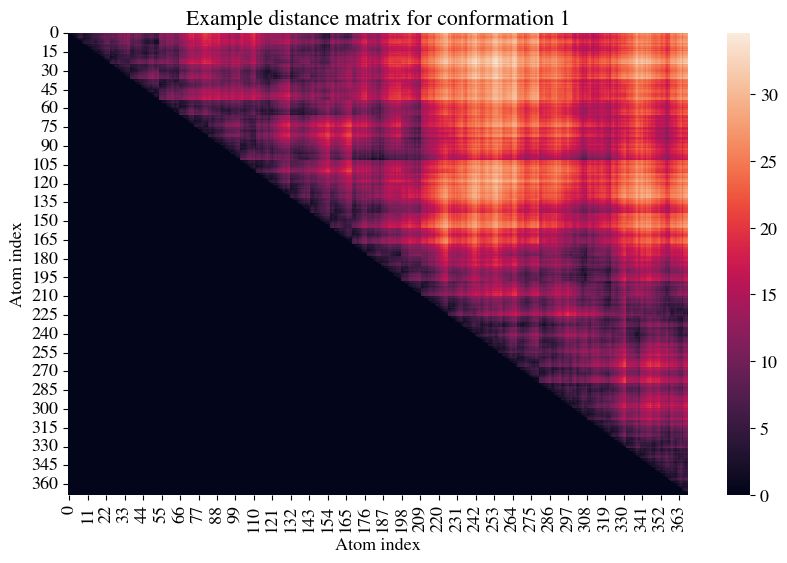

In [15]:
plt.figure(figsize=(10, 6))
d = distance_matrix(conformation_cords[0])
print(f"{np.count_nonzero(d)} non-zero distances were calculated")
sns.heatmap(d, cmap="rocket")
plt.title("Example distance matrix for conformation 1")
plt.xlabel("Atom index")
plt.ylabel("Atom index")
plt.show()

Having a constructor for the distance matrix for each conformation we code `calculate_dRMSD` following the equation of d-RMSD:
$$d-RMSD = \sqrt{\frac{1}{k} \sum_{i=1}^k||d_{i} - d_{i}`||^2}$$
where $d_{i}$ and $d_{i}`$ are the $i$-th indexed atom distance in the distance matrix for each of the two conformations we are comparing.

In [16]:
def calculate_dRMSD(D_X, D_Y):
    # k equals the number of non-zero elements in the distance matrix
    k = 67896
    return np.sqrt(np.sum((D_X - D_Y)**2)/k)

Finally we use the functions above to calculate the d-RMSD distances between all the confomrations and store them in a matrix, which we then pass in a dataframe and visualize them in a heatmap.

In [17]:
# initialize the matrix
conformation_drmsd = np.zeros((10, 10))
start_time = time.time()
for i in range(10):
    for j in range(i+1, 10):
        # Use the optimal translation and rotation functions and calculate the RMSD
        D_X = distance_matrix(conformation_cords[i])
        D_Y = distance_matrix(conformation_cords[j])
        dRMSD = calculate_dRMSD(D_X, D_Y)
        # populate the matrix
        conformation_drmsd[i, j] = dRMSD
end_time = time.time()
dRMSD_elapsed_time = end_time - start_time
# pass the matrix to a pandas dataframe
dRMSD_df = pd.DataFrame(conformation_drmsd, columns=[
                        f"Conf {i+1}" for i in range(10)], index=[f"Conf {i+1}" for i in range(10)])
dRMSD_df

,Conf 1,Conf 2,Conf 3,Conf 4,Conf 5,Conf 6,Conf 7,Conf 8,Conf 9,Conf 10
Conf 1,0.0,0.500692,6.894124,6.914342,7.291757,7.266159,6.260204,6.284922,6.322847,5.990427
Conf 2,0.0,0.000000,6.909511,6.930348,7.279089,7.253292,6.271565,6.295611,6.325953,5.988907
Conf 3,0.0,0.000000,0.000000,0.588339,5.618455,5.560859,5.597303,5.633184,5.784912,6.061184
Conf 4,0.0,0.000000,0.000000,0.000000,5.620324,5.556078,5.588811,5.632174,5.804209,6.068728
Conf 5,0.0,0.000000,0.000000,0.000000,0.000000,0.734798,5.470709,5.493745,6.300626,6.569163
Conf 6,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,5.470450,5.514616,6.348928,6.678870
Conf 7,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.521585,5.195701,5.389886
Conf 8,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.178072,5.356120
Conf 9,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.857084
Conf 10,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


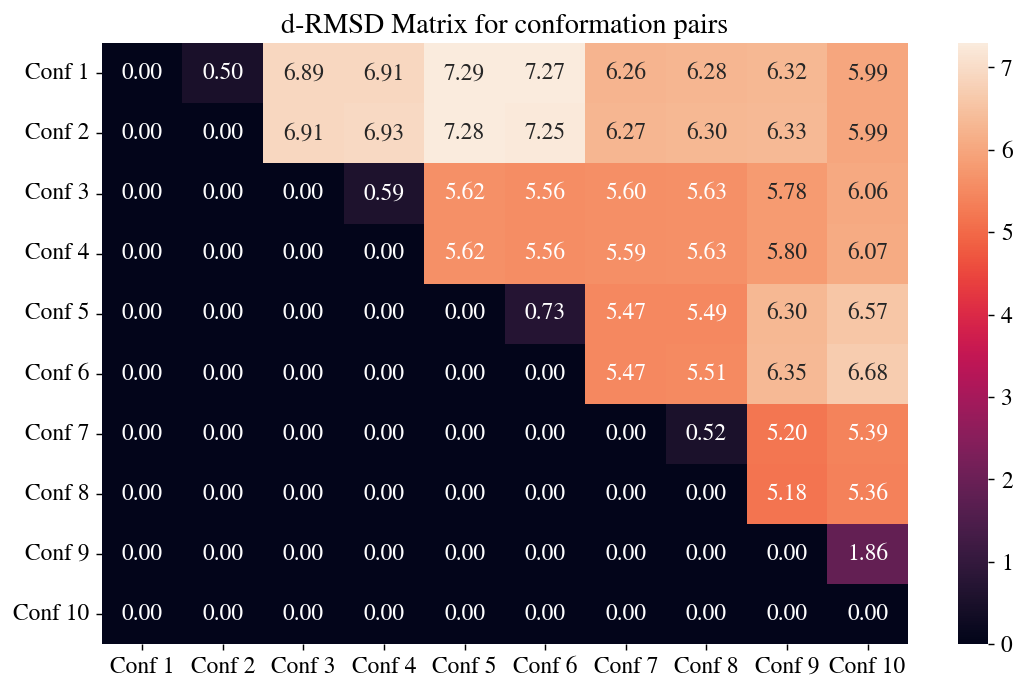

In [133]:
plt.figure(figsize=(10, 6), dpi=130)
sns.heatmap(dRMSD_df, annot=True, cmap="rocket", fmt=".2f")
plt.title("d-RMSD Matrix for conformation pairs")
plt.show()


In [19]:
dRMSD_dict = {}
for i in range(10):
    dRMSD_dict[f"Conformation {i + 1}"] = (np.concatenate(
        (conformation_drmsd[i, :], conformation_drmsd[:, i]), axis=0))
    dRMSD_dict[f"Conformation {i + 1}"] = dRMSD_dict[f"Conformation {i + 1}"][dRMSD_dict[f"Conformation {i + 1}"] != 0]
dRMSD_dict_df = pd.DataFrame(dRMSD_dict)

We procced with calculating the mean and median d-RMSD distance for each conformation with respect to the other conformations:

In [20]:
dRMSD_mean = dRMSD_dict_df.mean(axis=0).to_frame(name="Mean d-RMSD").T
dRMSD_mean

,Conformation 1,Conformation 2,Conformation 3,Conformation 4,Conformation 5,Conformation 6,Conformation 7,Conformation 8,Conformation 9,Conformation 10
Mean d-RMSD,5.969497,5.972774,5.405319,5.411484,5.59763,5.598228,5.085135,5.101114,5.457592,5.551152


In [21]:
dRMSD_median = dRMSD_dict_df.median(axis=0).to_frame(name="Median d-RMSD").T
dRMSD_median

,Conformation 1,Conformation 2,Conformation 3,Conformation 4,Conformation 5,Conformation 6,Conformation 7,Conformation 8,Conformation 9,Conformation 10
Median d-RMSD,6.322847,6.325953,5.633184,5.632174,5.620324,5.560859,5.470709,5.514616,5.804209,5.990427


**From the above its clear that the L1-centroid with d-RMSD metric is Conformation 7**

Finally we check if the following inequality holds true:


$cRMSD/\sqrt(n) \leq dRMSD \leq 2 (cRMSD)$

In [22]:
(RMSD_df / (X.shape[0])**(1/2) <= dRMSD_df) & (dRMSD_df <= 2*(RMSD_df))

,Conf 1,Conf 2,Conf 3,Conf 4,Conf 5,Conf 6,Conf 7,Conf 8,Conf 9,Conf 10
Conf 1,True,True,True,True,True,True,True,True,True,True
Conf 2,True,True,True,True,True,True,True,True,True,True
Conf 3,True,True,True,True,True,True,True,True,True,True
Conf 4,True,True,True,True,True,True,True,True,True,True
Conf 5,True,True,True,True,True,True,True,True,True,True
Conf 6,True,True,True,True,True,True,True,True,True,True
Conf 7,True,True,True,True,True,True,True,True,True,True
Conf 8,True,True,True,True,True,True,True,True,True,True
Conf 9,True,True,True,True,True,True,True,True,True,True
Conf 10,True,True,True,True,True,True,True,True,True,True


### **Task 3: Do they all 3 approaches yield the same centroid? How do they compare in terms of speed.**


In terms of speed as its evident below, cRMSD is $\approx1000$ times faster since we need to compute ${n \choose 2}$ distances, in this case $n=369$ thus $45$ distances. On the other hand in dRMSD we had to calculate $k= {369 \choose 2}$ thus  $k = 67896$ distances.

In [23]:
print(
    f"The speed of cRMSD claculation for the 10 conformations is: {round(cRMSD_elapsed_time,2)} seconds\n")
print(
    f"The speed of dRMSD claculation for the 10 conformations is: {round(dRMSD_elapsed_time,2)} seconds\n")


The speed of cRMSD claculation for the 10 conformations is: 0.03 seconds

The speed of dRMSD claculation for the 10 conformations is: 40.74 seconds



Additionally, the L1 centroids are different for cRMSD and dRMSD.

---

# **Problem 3: Distances**
Consider $50$ Ca atoms indexed $A102$ to $A152$ of main protease of SARS-COV-2 in complex with a peptide-like
inhibitor (PDB id: 6LU7). Construct the $51 \ by \ 51$ Cayley-Menger matrix B.

1. Compute $rank(B)$, explain why the obtained value is correct.

2. Perturb entries of B by $5\%$, an (maintaining symmetry, positive entries, 0's, 1's) then explain the new value of $rank(B)$. Compute Gram matrix G, apply SVD: $G = U\Sigma V^T$ . Now $S$ is the diagonal matrix containing the 3 largest singular values of G. Get the 3D coordinates as $\sqrt{S}U^T$ , and report the c-RMSD against the original structure.

## *Solution*
First of all we download and open the relevant PDB file and keep the rows containing backbone atoms $Ca$.

In [24]:
# Open the pdb file and read the lines
coord_lines = []
with open("6lu7.pdb", "r") as file:
    data = file.readlines()
    for line in data:
        # Pass the lines that start with ATOM to a list
        if (line.startswith("ATOM")) and ("CA" in line):
            coord_lines.append(line)
print(coord_lines)
print(f"We have extracted {len(coord_lines)} backbone atoms")

['ATOM      2  CA  SER A   1     -32.156   8.073  34.741  1.00 37.44           C  \n', 'ATOM      8  CA  GLY A   2     -29.510   6.712  37.092  1.00 34.67           C  \n', 'ATOM     12  CA  PHE A   3     -29.155   6.661  40.866  1.00 36.10           C  \n', 'ATOM     23  CA  ARG A   4     -26.277   8.066  42.915  1.00 38.88           C  \n', 'ATOM     34  CA  LYS A   5     -25.667   9.020  46.528  1.00 36.92           C  \n', 'ATOM     43  CA  MET A   6     -26.400  12.716  46.023  1.00 36.94           C  \n', 'ATOM     51  CA  ALA A   7     -25.496  15.526  48.417  1.00 31.84           C  \n', 'ATOM     56  CA  PHE A   8     -27.182  18.909  48.513  1.00 34.19           C  \n', 'ATOM     67  CA  PRO A   9     -25.340  21.872  46.956  1.00 37.27           C  \n', 'ATOM     74  CA  SER A  10     -23.037  23.278  49.626  1.00 38.41           C  \n', 'ATOM     80  CA  GLY A  11     -22.802  26.892  48.440  1.00 38.60           C  \n', 'ATOM     84  CA  LYS A  12     -25.146  28.293  51.0

The 6th column contains the residue sequence number while columns 7-9 contain the x, y, z coordinates of the atoms. Thus we use the residue atom index to extract the coordinates of the 50 Ca atoms indexed 102-151 and store them in a dataframe:

In [25]:
# Extract the coordinates from each list entry
# Grab the
coord_lines = [line.split()[5:9] for line in coord_lines]
coord_lines = np.array(coord_lines, dtype=float)

df = pd.DataFrame(coord_lines[:, 1:], columns=[
                  "X", "Y", "Z"], index=coord_lines[:, 0])
df = df.iloc[101:151]
print(f"The shape of the dataframe is {df.shape}")


The shape of the dataframe is (50, 3)


In [26]:
df.head()


,X,Y,Z
102.0,-33.343,26.180,60.877
103.0,-31.916,24.031,63.672
104.0,-33.501,20.580,63.455
105.0,-32.716,17.283,65.158
106.0,-33.120,14.410,62.707


### *Cayley-Menger matrix*

The Cayley-Menger matrix is defined as the distance matrix of the atoms $M_{ij} = \frac{1}{2}dist(p_i,p_j)^2$ augmented with a row and column of ones with a $[0,0]$ enty of 0. Thus we define `cayley_menger` to calculate the Cayley-Menger matrix of the 50 Ca atoms and find its rank.

In [27]:
def cayley_menger(X):
    N = X.shape[0]
    # initialize the M distance matrix
    M = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            # calculate each entry of the matrix
            distance = 1/2*(np.linalg.norm(X[i]-X[j]))**2
            # populate the matrix
            M[i, j] = distance
    # Augment matrix m with
    # number of atoms
    CM = np.zeros((N+1, N+1))
    CM[0, 1:] = np.ones(N)
    CM[1:, 0] = np.ones(N)
    CM[1:, 1:] = M
    return CM, M

The rank of the Cayley-Menger matrix is 5


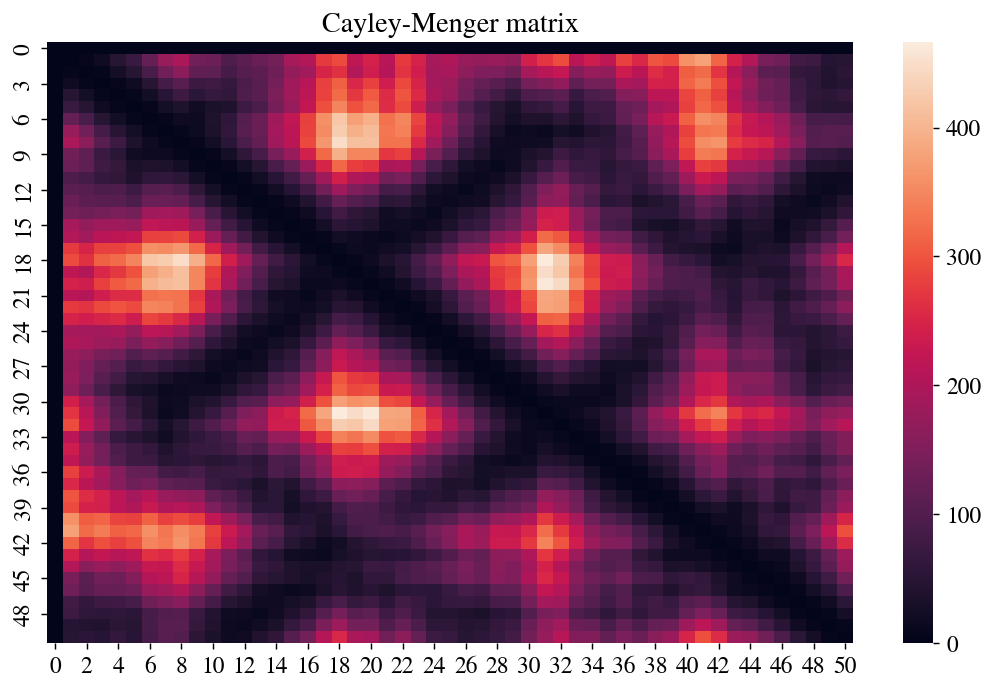

In [102]:
CM, M = cayley_menger(df.values)
print(
    f"The rank of the Cayley-Menger matrix is {np.linalg.matrix_rank(CM)}")
plt.figure(figsize=(10, 6), dpi=130)
plt.title("Cayley-Menger matrix")
sns.heatmap(CM, cmap="rocket")
plt.show()


The number of rows and columns of the CM matrix is 51 but its rank is only 5. This mean that the matrix ha has 5 linearly independent rows or columns and thus the atoms are aranged in a 5-th dimensional space

To perturb entries of $B$ by $5%$, we can create a 50 by 50 matrix which contains values -1 and 1 randomly placed which then we multiplie with $0.05$, this results in a matrix with elements $-0.05$ and $0.05$, with elementwise multiplication of this matrix with the original M matrix, we can create a matrix containing either $5\%$ or -$5\%$ os the values of the M matrix.

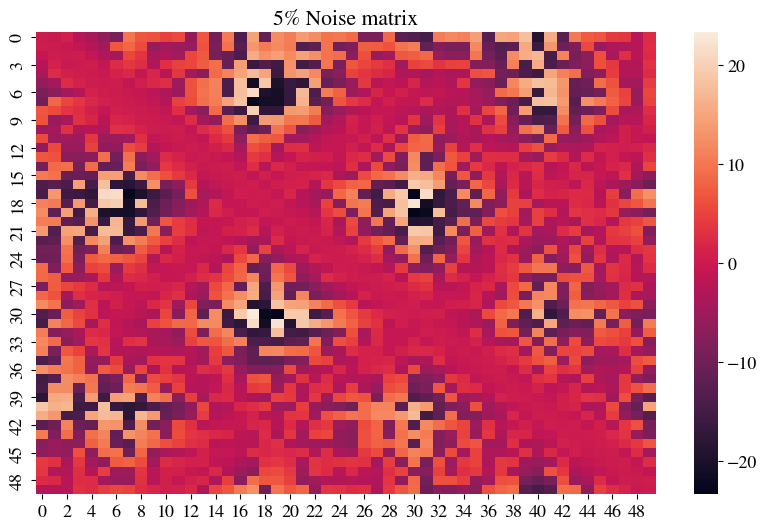

In [29]:
pertubing_matrix = np.zeros((50, 50))
pertubing_matrix = np.random.choice([-1, 1], size=(50, 50))*0.05*CM[1:, 1:]
plt.figure(figsize=(10, 6))
np.fill_diagonal(pertubing_matrix, 0)
plt.title("5% Noise matrix")
sns.heatmap(pertubing_matrix, cmap="rocket")
plt.show()


We then add the values of the noise matrix to the non augmented columns of the cayley menger matri.

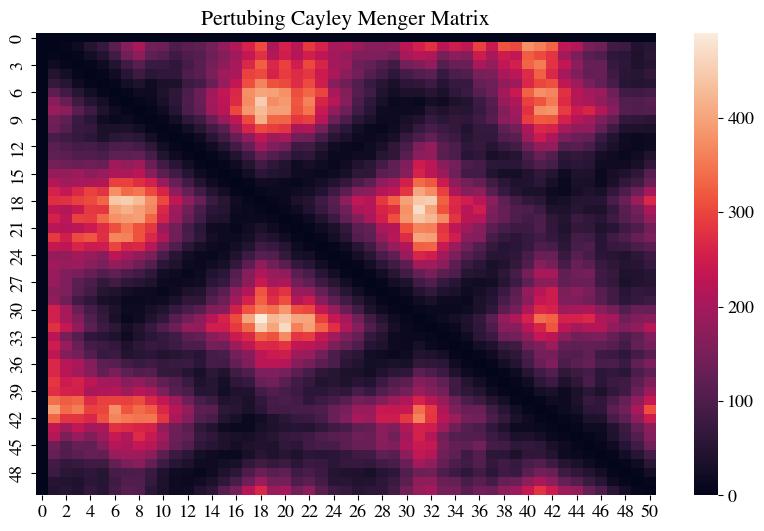

The rank of the perturbed Cayley-Menger matrix is 51


In [121]:
CM_perturbed = np.zeros((51, 51))
CM_perturbed[0, 0] = 0
CM_perturbed[0, 1:] = np.ones(50)
CM_perturbed[1:, 0] = np.ones(50)
CM_perturbed[1:, 1:] = CM[1:, 1:] + pertubing_matrix
plt.figure(figsize=(10, 6))
plt.title("Pertubing Cayley Menger Matrix")
sns.heatmap(CM_perturbed, cmap="rocket")
plt.show()
print(
    f"The rank of the perturbed Cayley-Menger matrix is {np.linalg.matrix_rank(CM_perturbed)}")


As we can see now the CM matrix is full rank. This is because the $5%$ pertrubation of the noise disturbed the linearity of the system and resulted in a non linear combinations of all the rows or columns.

### *Gram matrix*

To create the gram matrix of M We utilize the equation for each of the entries of a gram matrix based on the entries of the distance matrix M: 
$$G_{ij} = \frac{d_{i0}^2 - d_{ij}^2 + d^2_{j0}}{2}$$
Utilising SVD, we decompose G into $USV^T$, then we pick the largest three singular values of S and create a 3 by 3 diagonal matrix. The corresponding left singular vectors of G are picked via the first 3 columns of the U matrix. Thus we retrieve the 3-D coordinates as: $$M' = \sqrt{S}U^T$$Finally we utilize the method explained in the second problem to find the c-RMSD of M against M'

In [114]:
def gram_matrix(M):
    N = M.shape[0]
    G = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            G[i, j] = ((M[i, 0])**2 - (M[i, j])**2 + (M[0, j])**2)/2
    return G


G = gram_matrix(M)

SVD of the Gram matrix

In [115]:
U, S, V = np.linalg.svd(G)
# We pick the larget 3 singular values
S = S[0:3]
# We create a 3by3 matrix
matrix = np.zeros((3, 3))
# Step 2
np.fill_diagonal(matrix, S)
# Step 3
matrix = np.triu(matrix) + np.triu(matrix, 1).T


We pick the corresponding to the 3 first singular values first 3 singular vectors of U and get the coordinates as $\sqrt{S}U^T$


In [129]:
new_M = np.sqrt(matrix) @ U[:,0:3].T 

and calculate the c-RMSD

In [132]:
rmsd = calculate_RMSD(new_M.T,df.values)
print(f"The c-RMSD against the original structure is {rmsd}")

The c-RMSD against the original structure is 232.90436791830038
